In [1]:
import numpy as np
from scipy.stats import binom, nbinom

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", context='talk', font_scale=1.5, font="Helvetica")

# Why become a follower of Bayes? 

There are many reasons to switch from the tried-and-true frequentist
approaches to make sense of biological data to the Bayesian realm of
the highest density intervals and posterior predictive distributions. In my
view, one of the best reasons is the strange way that the ``intention'' of
the person conducting an experiment can affect the outcome of the
frequentist approach. I first encountered this example in John Kruschke's
fantastic book, [_Doing Bayesian Data Analysis_](https://sites.google.com/site/doingbayesiandataanalysis/).

## A Dataset of $N$ coin tosses 

Consider that you have been given a dataset containing the outcomes of
$N=24$ coin flips, with $k=7$ are heads. Our question is quite simple, ``is the coin fair?''

Framing the question in a way that demands a yes/no answer, is at the very
heart of null hypothesis significant testing that has been the most common
way to analyze experimental results, since it's generally the only way that
statistics is taught scientist. 

To answer this question, we should calculate the dreaded $p$-value. It
seems even the most well-qualified of people disagree about what $p$-value
actually means (For example, see [The American Statistical Association
statement on
P-values](https://www.amstat.org/asa/files/pdfs/p-valuestatement.pdf)). 

The problem in our coin-flips case is quite instructive since it highlights the general
problems when one attempts to calculate $p$-value. 

### What if the experiment was stopped after it reached $N$ data points?

In this scenario, the experimenter simply wanted $N$ data points, and after
she flipped $24$ coins, she stopped. In that case, we can simply use the
binomial distribution:

$$f(k) = \binom{n}{k} p^{k} (1 - p)^{n-k}$$

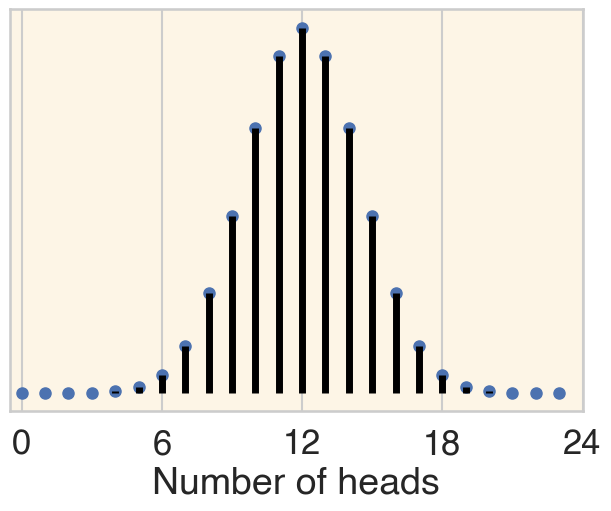

In [2]:
n, p = 24, 0.5
mean, var, skew, kurt = binom.stats(n, p, moments='mvsk')

fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(6,5),
    constrained_layout=True)

x = np.arange(binom.ppf(0.0, n, p),
              binom.ppf(1, n, p))
ax.plot(x, binom.pmf(x, n, p), 'bo', ms=8, label='binom pmf')
ax.vlines(x, 0, binom.pmf(x, n, p), colors='black', lw=5, alpha=1)
ax.set_facecolor('oldlace')
ax.set(xlim=(-0.5,24), xticks=np.linspace(0, 24, 5), yticks=[], xlabel='Number of heads');

In order to calculate $p-$value, we have to calculate the probability of getting $k=7$ or more exterme results given $p=0.5$:

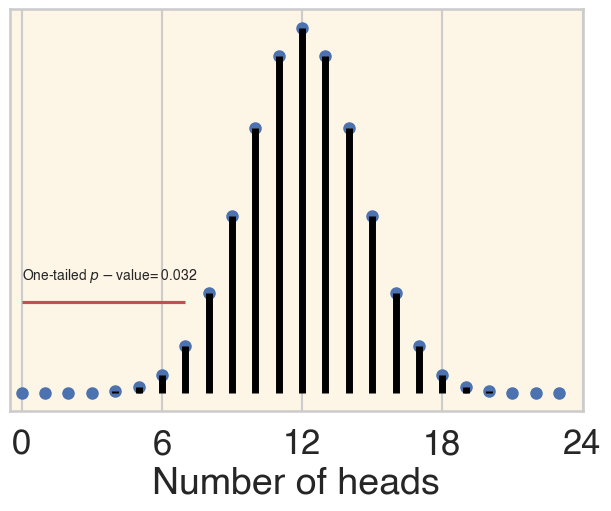

In [3]:
n, p = 24, 0.5
mean, var, skew, kurt = binom.stats(n, p, moments='mvsk')

fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(6,5),
    constrained_layout=True)

x = np.arange(binom.ppf(0.0, n, p),
              binom.ppf(1, n, p))
ax.plot(x, binom.pmf(x, n, p), 'bo', ms=8, label='binom pmf')
ax.vlines(x, 0, binom.pmf(x, n, p), colors='black', lw=5, alpha=1)
ax.set_facecolor('oldlace')

ax.hlines(0.04, 0, 7, 'r')
ax.text(0, 0.05, r'One-tailed $p-$value= '+str(np.round(binom.cdf(7, 24, 0.5), decimals=3)), size=10)
ax.set(xlim=(-0.5,24), xticks=np.linspace(0, 24, 5), yticks=[], xlabel='Number of heads');

The threshold $5\%$ for $p-$value corresponds to the two-tailed case. In our one-tailed case, we should compare our $p-$value to $2.5\%$. Since our $p-$value $> 2.5\%$, we cannot reject the null-hypothesis that the coin is fair.

### What if the experiment was stopped after it reached $k$ heads?

The problem is that, if the experiemnt was stopped when we reached $k=7$ heads, then the design of this experiment would be best captured by the negative binomial distribution:

$$f(k) = \binom{n - 1}{k -1} p^{k} (1 - p)^{n-k} \quad ,$$

where the distirbution is counting $n$ trials given $k$ heads.

(_Note:_ the negative binomila distribution can be formulated in many different ways, see [Wikipedia](https://en.wikipedia.org/wiki/Negative_binomial_distribution).)

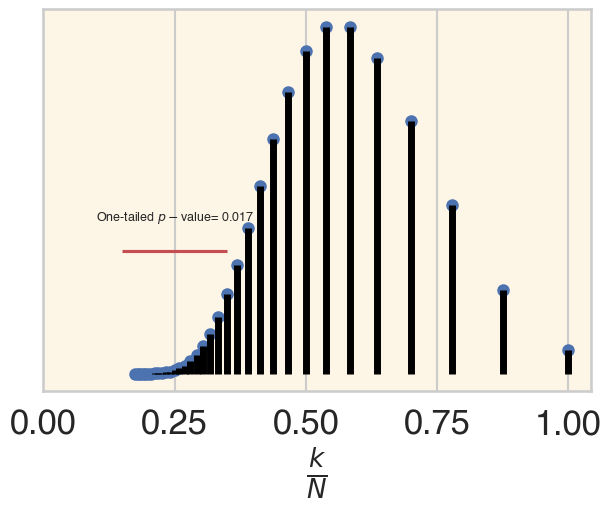

In [5]:
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(6,5),
    constrained_layout=True)

n_draws = np.arange(40, 6, -1)
k, p = 7, 0.5
pmf_vals = np.array([nbinom.pmf(n-k, k, p) for n in n_draws])
ax.plot(7/n_draws, pmf_vals, 'bo', ms=8, label='nbinom pmf')
ax.vlines(7/n_draws, 0, pmf_vals, colors='black', lw=5, alpha=1)
ax.set_facecolor('oldlace')

pval = np.sum(pmf_vals[np.where(n_draws>23)])

ax.hlines(0.04, 0.15, 0.35, 'r')
ax.text(0.1, 0.05, r'One-tailed $p-$value= '+str(np.round(pval, decimals=3)), size=9)
ax.set(xticks=np.linspace(0, 1, 5), yticks=[], xlabel=r'$\frac{k}{N}$');

Strangely, with the negative binomial distribution, we can now reject the
null hypothesis that the coin is fair!

## The Bayesian solution

So how could we resolve this issue, especially since the intention of the
experimenter should not have such drastic effect on our inference of
statistical significance. One way out is to dispense with null-hypothesis
significance testing (NHST) entirely, and instead try to infer the probability of
having a head ($\theta$) given our observation that $k$ heads were observed
after $n$ throws. To put it in mathematical terms, we want to calculate 

$$\mathrm{Pr}(\theta | \mathrm{data}) \quad ,$$

which is quite different from what we do to calculate $p-$value:

$$p-\mathrm{value} = p(D_{\theta, I}  \succcurlyeq D_{\mathrm{observed}} |
\theta, I) \quad ,$$

which means getting data as extreme or more extreme than observed data
given probability $\theta$ and the intention of the experimenter $I$.

Since our observations can assume to possible values, i.e., head or tail,
we can make a simple model to infer $\theta$:

$$ y \sim \mathrm{Bernoulli}(\theta) \quad ,$$

$$\theta \sim \mathrm{Beta}(a, b) \quad .$$

The choice of Beta distribution as our prior is simply based on the fact
that Beta and the Bernoulli likelihood function belong to the same family,
i.e., Beta is a _conjugate prior_ for the Bernoulli likelihood function
(you can find a very useful list of likelihood functions and their
conjugate priors on
[Wikipedia](https://en.wikipedia.org/wiki/Conjugate_prior)). We can
construct our model using [PyMC](https://www.pymc.io/welcome.html).

In [2]:
import arviz as az
import pymc as pm

In [21]:
n = 24
k = 7
data = np.concatenate((np.zeros(n - k), np.ones(k)))

with pm.Model() as model:
    θ = pm.Beta('θ', alpha=0.5, beta=0.5)
    y = pm.Bernoulli('y', p=θ, observed=data)
    trace = pm.sample(tune=1000, draws=10000, target_accept=0.95, return_inferencedata=True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]


Output()

Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 2 seconds.


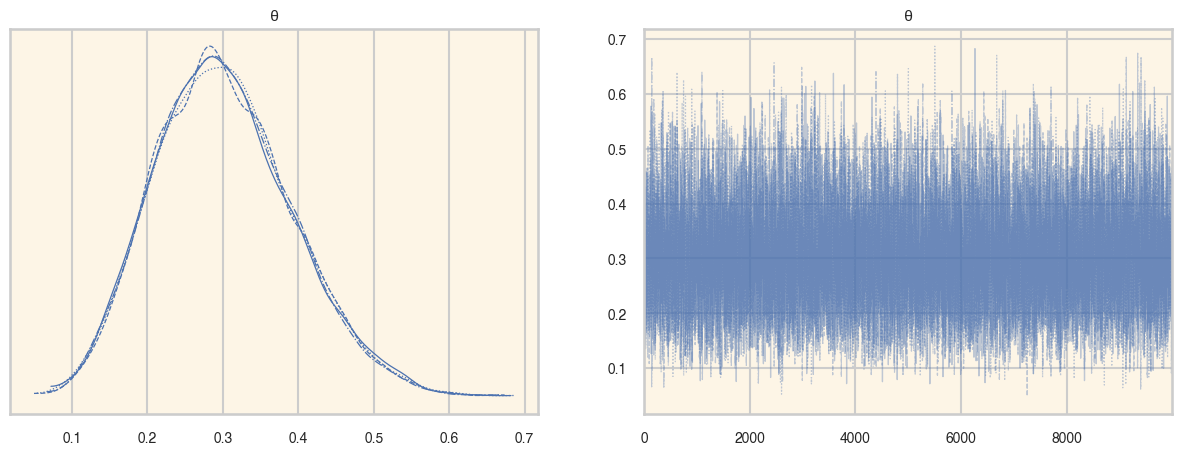

In [82]:
fig, axs = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(15,5))

axs = axs.reshape(1,2)
az.plot_trace(trace, axes=axs)

axs = axs.flatten()
for ax in axs:
    ax.set_facecolor('oldlace')

The summary of our inference for $\theta$ is shown in the table below:

In [23]:
az.summary(trace, round_to=2, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
θ,0.3,0.09,0.13,0.48,0.0,0.0,13467.12,11956.47,1.0


We can visualize posterior distribution, which
shows the posterior $95\%$ **highest density interval** (HDI). HDI is the bayesian
equivalent to the confidence interval (CI), however it provides several
advantages over CI, since it specifically reflects:

+ the most credible region of the posterior distribution(s), 

+ it can be interpreted probabilistically. 

However, CI can be as confusing to interpret as p-value!

For more on the non-equivalence of HDI and CI, see [Pragmatism should Not be a Substitute for Statistical Literacy](https://online.ucpress.edu/collabra/article/5/1/13/112982/Pragmatism-should-Not-be-a-Substitute-for).

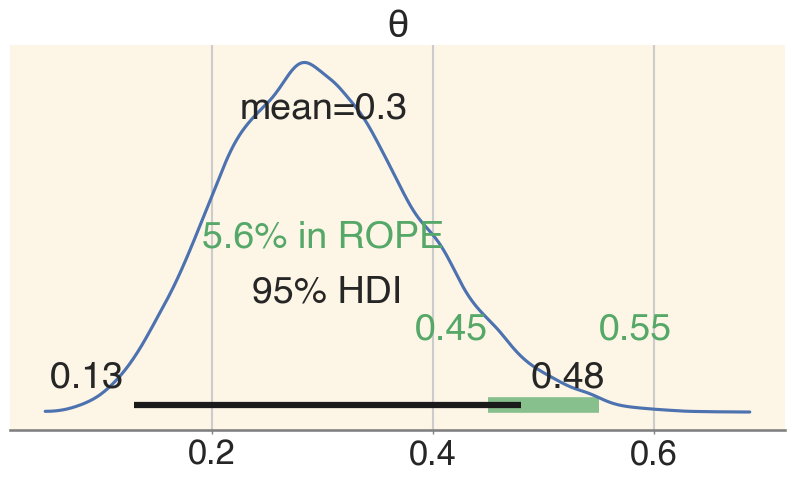

In [85]:
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(10,5))

az.plot_posterior(trace, hdi_prob=0.95, rope=(0.45, 0.55), ax=ax)
ax.set_facecolor('oldlace')

The green region represents the _region of practical eqivalence_ (ROPE).
Basically, this region reflects our belief with respect to values for
$\theta$ that would be considered fair (i.e., our null hypothesis). By
comparing HDI with ROPE we can decide if we can make a decision about the
fairness of coins in based on our observation:

+ if ROPE and HDI completely overlap, the coin is fair and our null
  hypothesis is accepted.

+ if ROPE and HDI partially overlap, we cannot make a judgment about the
  fairness of the coin based on the data.

+ if ROPE and HDI do not overlap, then the coin is unfair.

While some scientists would find this _subjective_ approach to analyzing
data a disturbing, it should be noted that this approach is merely explicit
in its subjective aspect whereas the frequentist methods frequently imply a
level objectivity that in reality does not exist.

